In [1]:
import pandas as pd
import re

hits_excel_path = 'Supplementary_Table_11_CRISPR_DepMap_analysis.xlsx'
prediction_data = pd.read_excel(hits_excel_path, sheet_name=None)

In [2]:
# We can see the structure of hits_data : it's a dictionary with sheet names as keys, containing the dataframes as values

prediction_data['SMARCA4'].head()

,mutant,gene,num_lines_high,num_lines_low,estimate,p_adj
0,SMARCA4,CDAN1,97,98,-0.485750,4.039878e-09
1,SMARCA4,CDIN1,97,98,-0.224043,1.315044e-08
2,SMARCA4,MICOS10,97,98,-0.255113,1.518594e-06
3,SMARCA4,CBFB,97,98,-0.196786,1.982028e-06
4,SMARCA4,SDHD,97,98,-0.254965,3.671643e-06


In [3]:
# We can see the shape of the dataframe : it contains thousants of tested pairs. We want to extract those with a sufficiently high p_adj value

prediction_data['SMARCA4'].shape

(10052, 6)

In [4]:
# We first get the full list of genes that were tested for synthetic lethality in our study 

tested_genes = prediction_data.keys()
tested_genes_list = list(tested_genes)

print(tested_genes_list)

['ARID1A', 'ARID1B', 'ARID2', 'PBRM1', 'SMARCA2', 'SMARCA4', 'SMARCB1', 'BAP1', 'CREBBP', 'EED', 'KMT2C', 'KMT2D', 'SETD2']


In [5]:
# now, we can make sure to drop all gene pairs that don't have high enough p_adj values, for all tested genes
hits_data = {}

for gene in tested_genes_list:
    hits_data[gene] = prediction_data[gene][prediction_data[gene]['p_adj'] < 0.001]

# We get a much smaller proportion of the initial data (only 105 lines), which is expected. 

hits_data['SMARCA4'].shape

(105, 6)

In [18]:
# Then, we get all gene pairs that are included in the SynLethDB dataset : this is what we will compare our predictions to

def load_bm_data(filename):
  gene_sl_gene_df = pd.read_csv(filename, sep='\t')

  gene_sl_gene_df2 = gene_sl_gene_df[['x_name', 'y_name', 'rel_source']]

  positive_bm_df = gene_sl_gene_df2[gene_sl_gene_df['x_name'].isin(tested_genes_list) | gene_sl_gene_df['y_name'].isin(tested_genes_list)]

  return positive_bm_df


positive_bm_df = load_bm_data(filename='gene_sl_gene.tsv')

positive_bm_df.head()

,x_name,y_name,rel_source
173,PTTG1,CREBBP,Text Mining
346,ARID1A,MMP19,Computational Prediction
422,CDH1,SMARCA4,High Throughput
536,ARID2,CDK9,High Throughput
759,KMT2D,MYH4,Computational Prediction


In [8]:
print(positive_bm_df.shape)

(261, 3)


In [9]:
# Now, we demonstrate our pipeline with SMARCA4 as the gene of interest

tested_gene = 'ARID1B'

# We will store all SLI pairs as pandas dataframes withing dictionaries, similar to how our hits_data is structured

studied_sli_list = known_sli = identified_sli = {}

# First, we get the subset of known SLIs from SynLethDB where either 'x_name' or 'y_name' is the tested_gene
known_sli[tested_gene] = positive_bm_df[
    (positive_bm_df['x_name'] == tested_gene) | (positive_bm_df['y_name'] == tested_gene)
].copy()  # Make a copy to avoid setting on a slice

known_sli[tested_gene]

,x_name,y_name,rel_source
3658,ARID1B,NRAS,GenomeRNAi
4839,ARID1B,THBS3,Computational Prediction
5196,KRAS,ARID1B,RNAi Screen;High Throughput
5914,ARID1A,ARID1B,Text Mining;High Throughput
13634,ARID1B,NINJ2,Computational Prediction
14388,ARID1B,BCLAF1,Computational Prediction
16569,ARID1B,SHARPIN,Computational Prediction
20539,ARID1B,HRAS,GenomeRNAi
26278,ARID1B,TBP,Computational Prediction
26909,ARID1B,BPTF,Computational Prediction


In [22]:
# Then, we make sure the database is properly structured for our analysis, distinguishing between the "mutant" gene of interest and the other gene in the pair

# Create a copy to avoid modifying the original DataFrame

known_sli_tidy = {}

known_sli_tidy[tested_gene] = known_sli[tested_gene].copy()

# Check if tested_gene is in y_name column
mask = known_sli_tidy[tested_gene]['y_name'] == tested_gene  # Fix: Compare only y_name column

if mask.any():
    # Swap x_name and y_name where tested_gene is in y_name
    known_sli_tidy[tested_gene].loc[mask, ['x_name', 'y_name']] = known_sli_tidy[tested_gene].loc[mask, ['y_name', 'x_name']].values

# Rename the columns
known_sli_tidy[tested_gene].columns = ['mutant', 'gene', 'source']

known_sli_tidy[tested_gene]

,mutant,gene,source
68507,ARID1B,ARID1A,High Throughput


In [23]:
known_sli_filtered = {}

known_sli_filtered[tested_gene] = pd.merge(left=known_sli_tidy[tested_gene], right=prediction_data[tested_gene], on="gene", how="left")

known_sli_filtered[tested_gene] = known_sli_filtered[tested_gene].drop(columns=["mutant_y", "num_lines_high", "num_lines_low"])

known_sli_filtered[tested_gene]= known_sli_filtered[tested_gene].rename(columns={"mutant_x":"mutant"})

known_sli_filtered[tested_gene] = known_sli_filtered[tested_gene].dropna()

sources_to_exclude = "Text Mining|Computational Prediction|Drug Inhibition"

known_sli_filtered[tested_gene] = known_sli_filtered[tested_gene][~known_sli_filtered[tested_gene]["source"].str.contains(sources_to_exclude)]

known_sli_filtered[tested_gene] 

,mutant,gene,source,estimate,p_adj
0,ARID1B,ARID1A,High Throughput,0.064127,1.0


In [24]:
# Let's merge our benchmark data with our model's outputs so that we can compare the two
# Here, we also filter our data to only include relevant benchmark sources, and gene pairs that were studied by our model
def filter_benchmark_data(bm_data, prediction_data, printratio = "False"):
    known_sli_filtered = {}
    pattern = "Text Mining|Computational Prediction|Drug Inhibition"
    for tested_gene in tested_genes_list:
        # Get the subset of the DataFrame where either 'x_name' or 'y_name' is the tested_gene
        known_sli[tested_gene] = bm_data[
            (bm_data['x_name'] == tested_gene) | (bm_data['y_name'] == tested_gene)
        ].copy()  # Make a copy to avoid setting on a slice

        # Create a copy to avoid modifying the original DataFrame
        known_sli_tidy[tested_gene] = known_sli[tested_gene].copy()

        # Check if tested_gene is in y_name column
        mask = known_sli_tidy[tested_gene]['y_name'] == tested_gene  # Fix: Compare only y_name column

        if mask.any():
            # Swap x_name and y_name where tested_gene is in y_name
            known_sli_tidy[tested_gene].loc[mask, ['x_name', 'y_name']] = known_sli_tidy[tested_gene].loc[mask, ['y_name', 'x_name']].values

        # Rename the columns
        known_sli_tidy[tested_gene].columns = ['mutant', 'gene', 'source']

        known_sli_filtered[tested_gene] = pd.merge(left=known_sli_tidy[tested_gene], right=prediction_data[tested_gene], on="gene", how="left")

        known_sli_filtered[tested_gene] = known_sli_filtered[tested_gene].drop(columns=["mutant_y", "num_lines_high", "num_lines_low"])

        known_sli_filtered[tested_gene]= known_sli_filtered[tested_gene].rename(columns={"mutant_x":"mutant"})

        known_sli_filtered[tested_gene] = known_sli_filtered[tested_gene].dropna()

        pattern = "Text Mining|Computational Prediction|Drug Inhibition"

        known_sli_filtered[tested_gene] = known_sli_filtered[tested_gene][~known_sli_filtered[tested_gene]["source"].str.contains(pattern)]

        if printratio == "True":
            included_genes_n = known_sli_filtered[tested_gene].shape[0]
            synlethdb_genes_n = known_sli_tidy[tested_gene].shape[0]
            if synlethdb_genes_n != 0:
                included_genes_ratio= included_genes_n / synlethdb_genes_n
                print(f"{tested_gene} included genes ratio:    {included_genes_ratio:.3f}     sample size : {included_genes_n}/{synlethdb_genes_n}")
            else:
                included_genes_ratio[tested_gene] = 'N/A'
                print(f"{tested_gene} included genes ratio:    {included_genes_ratio:.3f}     sample size : {included_genes_n}/{synlethdb_genes_n}")

    return known_sli_filtered


known_sli_filtered = filter_benchmark_data(positive_bm_df, prediction_data, printratio="True")

known_sli_filtered['ARID1B']

ARID1A included genes ratio:    0.400     sample size : 10/25
ARID1B included genes ratio:    0.250     sample size : 3/12
ARID2 included genes ratio:    0.941     sample size : 32/34
PBRM1 included genes ratio:    0.875     sample size : 21/24
SMARCA2 included genes ratio:    0.125     sample size : 1/8
SMARCA4 included genes ratio:    0.576     sample size : 19/33
SMARCB1 included genes ratio:    0.692     sample size : 18/26
BAP1 included genes ratio:    0.250     sample size : 1/4
CREBBP included genes ratio:    0.038     sample size : 2/52
EED included genes ratio:    0.000     sample size : 0/2
KMT2C included genes ratio:    0.000     sample size : 0/20
KMT2D included genes ratio:    0.467     sample size : 7/15
SETD2 included genes ratio:    0.933     sample size : 14/15


,mutant,gene,source,estimate,p_adj
0,ARID1B,NRAS,GenomeRNAi,0.012732,1.000000
2,ARID1B,KRAS,RNAi Screen;High Throughput,0.004076,1.000000
7,ARID1B,HRAS,GenomeRNAi,-0.010925,0.789225


In [25]:
# We can now export our filtered data to excel
def save_data_to_excel(bm_data, filename):
    with pd.ExcelWriter(filename, engine="openpyxl") as writer:
        for sheet_name, df in bm_data.items():
            df.to_excel(writer, sheet_name=sheet_name, index=False)

save_data_to_excel(bm_data=known_sli_filtered, filename="synlethdb_known_slis.xlsx")

In [26]:
# Using the exact same logic as before, we create and filter our negative benchmark data

gene_nonsl_gene_df = pd.read_csv('gene_nonsl_gene.tsv', sep='\t')

gene_nonsl_gene_df2 = gene_nonsl_gene_df[['x_name', 'y_name', 'rel_source']]

negative_bm_df = gene_nonsl_gene_df2[gene_nonsl_gene_df2['x_name'].isin(tested_genes_list) | gene_nonsl_gene_df2['y_name'].isin(tested_genes_list)]

negative_bm_df.head()

,x_name,y_name,rel_source
9,CREBBP,KDM6B,High Throughput
125,ABL1,SETD2,High Throughput
152,ARID1A,ARID2,High Throughput
353,CREBBP,SIRT1,High Throughput
526,PIK3R1,SETD2,High Throughput


In [27]:
known_nonsli_filtered = filter_benchmark_data(negative_bm_df, prediction_data)

known_nonsli_filtered['ARID1B']

,mutant,gene,source,estimate,p_adj
0,ARID1B,ARID1A,High Throughput,0.064127,1.0


In [29]:
# Now, let's aggregate all of our data in a single table so that we can evaluate the model's performance on different metrics.

def dictionary_to_df(data_dict):
    result = pd.DataFrame()  
    for key in data_dict.keys():  
        result = pd.concat([result, data_dict[key]], ignore_index=True)  

    return result  

known_sli_table = dictionary_to_df(known_sli_filtered) 

known_nonsli_table = dictionary_to_df(known_nonsli_filtered)

In [31]:
known_sli_table

,mutant,gene,source,estimate,p_adj
0,ARID1A,RRM2,High Throughput,-0.034285,0.530385
1,ARID1A,CHEK1,High Throughput;CRISPR/CRISPRi,0.007565,1.000000
2,ARID1A,MAP3K1,High Throughput,0.016090,1.000000
3,ARID1A,APC,High Throughput,-0.013477,0.922808
4,ARID1A,SMO,High Throughput,-0.010748,0.880468
...,...,...,...,...,...
123,SETD2,TSC1,High Throughput,0.003296,1.000000
124,SETD2,CDK9,CRISPR/CRISPRi,0.043535,1.000000
125,SETD2,HDAC2,High Throughput,-0.001150,0.987453
126,SETD2,SMO,High Throughput,-0.013397,0.853697


In [32]:
known_nonsli_table

,mutant,gene,source,estimate,p_adj
0,ARID1A,ARID2,High Throughput,0.013275,1.000000
1,ARID1A,RRM2,High Throughput,-0.034285,0.530385
2,ARID1A,CASP8,High Throughput,-0.034318,0.505600
3,ARID1A,CHEK2,High Throughput,-0.058370,0.162479
4,ARID1A,KDM6A,High Throughput,-0.001018,0.992384
...,...,...,...,...,...
562,SETD2,EZH2,High Throughput,-0.070590,0.470767
563,SETD2,FLT3,High Throughput,-0.028196,0.612303
564,SETD2,BRAF,High Throughput,-0.055545,0.385070
565,SETD2,CDKN1B,High Throughput,0.000423,1.000000


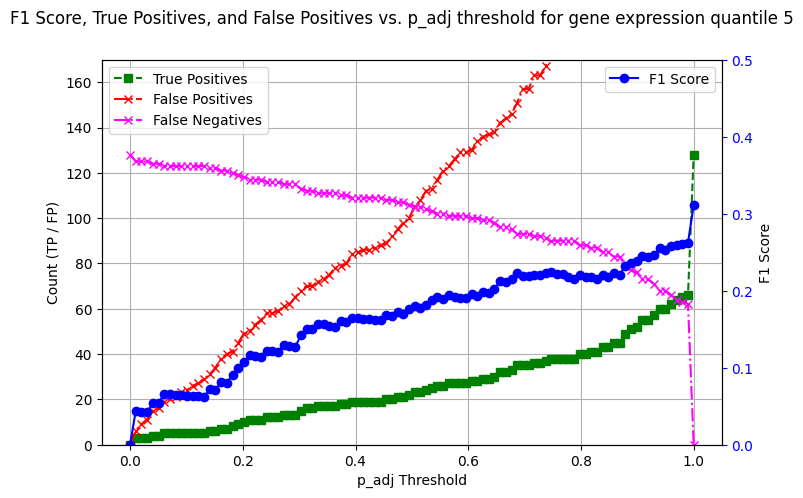

In [33]:
# Let's calculate true positives, false positives, etc :

import numpy as np
import matplotlib.pyplot as plt

def plot_F1_score(known_sli_table, known_nonsli_table, quantile):
    # Define a range of p_adj thresholds
    p_adj_values = np.linspace(0, 1, 100)  # Adjust range as needed
    f1_scores = []
    true_positives_list = []
    false_positives_list = []
    false_negatives_list = []

    # Compute F1-score, TP, and FP for each threshold
    for p_adj_tresh in p_adj_values:
        true_positives = (known_sli_table["p_adj"] < p_adj_tresh).sum()
        false_positives = (known_nonsli_table["p_adj"] < p_adj_tresh).sum()
        false_negatives = (known_sli_table["p_adj"] > p_adj_tresh).sum()

        # Store TP and FP
        true_positives_list.append(true_positives)
        false_positives_list.append(false_positives)
        false_negatives_list.append(false_negatives)

        # Precision and Recall
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

        # Compute F1-score and scale by 100
        F1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(F1_score)

    # Create figure and axis
    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Primary Y-axis (TP and FP)
    ax1.plot(p_adj_values, true_positives_list, marker='s', linestyle='--', label="True Positives", color='green')
    ax1.plot(p_adj_values, false_positives_list, marker='x', linestyle='-.', label="False Positives", color='red')
    ax1.plot(p_adj_values, false_negatives_list, marker='x', linestyle='-.', label="False Negatives", color='magenta')
    ax1.set_xlabel("p_adj Threshold")
    ax1.set_ylabel("Count (TP / FP)")
    ax1.tick_params(axis='y')
    ax1.set_ylim(0, 170)  # Primary Y-axis (True Positives / False Positives)
    

    # Secondary Y-axis for F1-score
    ax2 = ax1.twinx()
    ax2.plot(p_adj_values, f1_scores, marker='o', linestyle='-', label="F1 Score", color='blue')
    ax2.set_ylabel("F1 Score")
    ax2.tick_params(axis='y', colors='blue')
    ax2.set_ylim(0, 0.50)  # Secondary Y-axis (F1 Score)

    # Title and legend
    fig.suptitle(f"F1 Score, True Positives, and False Positives vs. p_adj threshold for gene expression quantile {quantile}")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    ax1.grid(True)

    plt.show()

plot_F1_score(known_sli_table, known_nonsli_table, quantile=5)

# Now benchmarking the different quantile tresholds

In [16]:
import pandas as pd
# Loading all of the data

prediction_data_Q5 = pd.read_excel("CRISPR_DepMap_final_analysis_Q5.xlsx", sheet_name=None)

prediction_data_Q10 = pd.read_excel("CRISPR_DepMap_final_analysis_Q10.xlsx", sheet_name=None)

prediction_data_Q15 = pd.read_excel("CRISPR_DepMap_final_analysis_Q15.xlsx", sheet_name=None)

prediction_data_Q20 = pd.read_excel("CRISPR_DepMap_final_analysis_Q20.xlsx", sheet_name=None)

prediction_data_Q25 = pd.read_excel("CRISPR_DepMap_final_analysis_Q25.xlsx", sheet_name=None)

In [ ]:
known_sli_filtered_Q5 = filter_benchmark_data(positive_bm_df, prediction_data_Q5)

known_sli_filtered_Q10 = filter_benchmark_data(positive_bm_df, prediction_data_Q10)

known_sli_filtered_Q15 = filter_benchmark_data(positive_bm_df, prediction_data_Q15)

known_sli_filtered_Q20 = filter_benchmark_data(positive_bm_df, prediction_data_Q20)

known_sli_filtered_Q25 = filter_benchmark_data(positive_bm_df, prediction_data_Q25)

In [82]:
known_sli_filtered_fused = {}

for mutant in tested_genes_list:
    known_sli_filtered_fused[mutant] = known_sli_filtered_Q5[mutant][["mutant", "gene", "source"]].copy()
    for quantile in range(5, 30, 5):
        known_sli_filtered_QX = globals().get(f"known_sli_filtered_Q{quantile}")
        column_name = f"p_adj_Q{quantile}"
        known_sli_filtered_fused[mutant][column_name] = known_sli_filtered_QX[mutant]["p_adj"]
        

In [87]:
known_nonsli_filtered_Q5 = filter_benchmark_data(negative_bm_df, prediction_data_Q5)

known_nonsli_filtered_Q10 = filter_benchmark_data(negative_bm_df, prediction_data_Q10)

known_nonsli_filtered_Q15 = filter_benchmark_data(negative_bm_df, prediction_data_Q15)

known_nonsli_filtered_Q20 = filter_benchmark_data(negative_bm_df, prediction_data_Q20)

known_nonsli_filtered_Q25 = filter_benchmark_data(negative_bm_df, prediction_data_Q25)

In [88]:
known_nonsli_filtered_fused = {}

for mutant in tested_genes_list:
    known_nonsli_filtered_fused[mutant] = known_nonsli_filtered_Q5[mutant][["mutant", "gene", "source"]].copy()
    for quantile in range(5, 30, 5):
        known_nonsli_filtered_QX = globals().get(f"known_nonsli_filtered_Q{quantile}")
        column_name = f"p_adj_Q{quantile}"
        known_nonsli_filtered_fused[mutant][column_name] = known_nonsli_filtered_QX[mutant]["p_adj"]

In [92]:
save_data_to_excel(known_sli_filtered_fused, "synlethdb_known_slis.xlsx")

save_data_to_excel(known_nonsli_filtered_fused, "synlethdb_known_nonslis.xlsx")

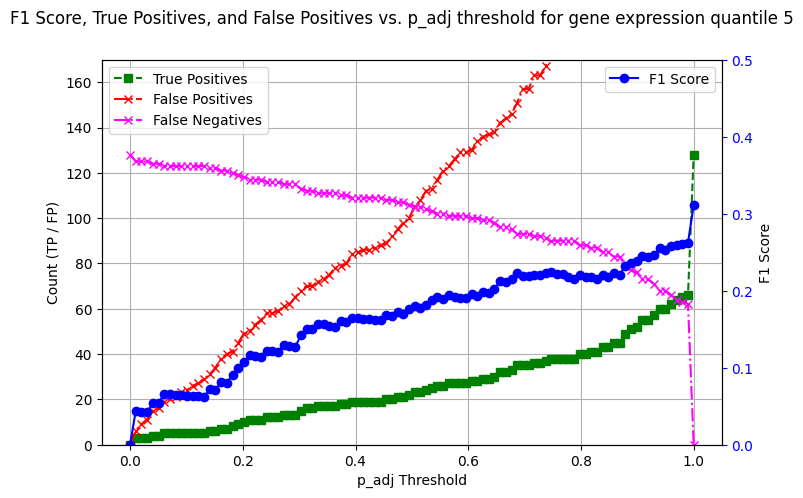

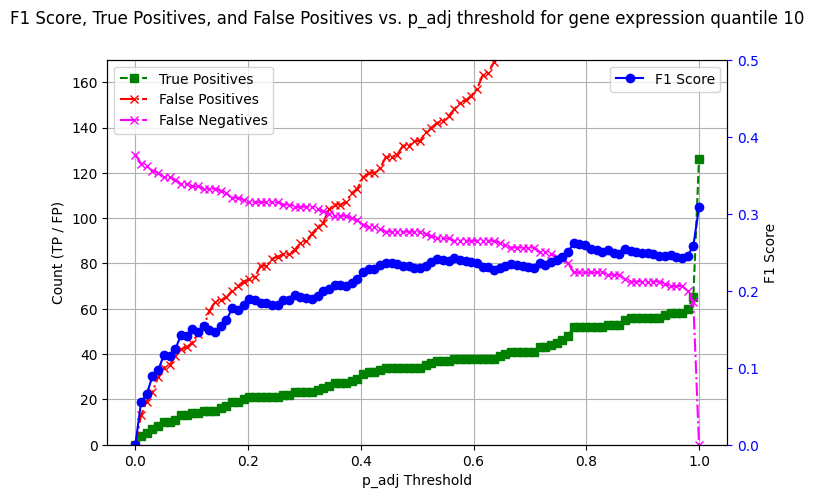

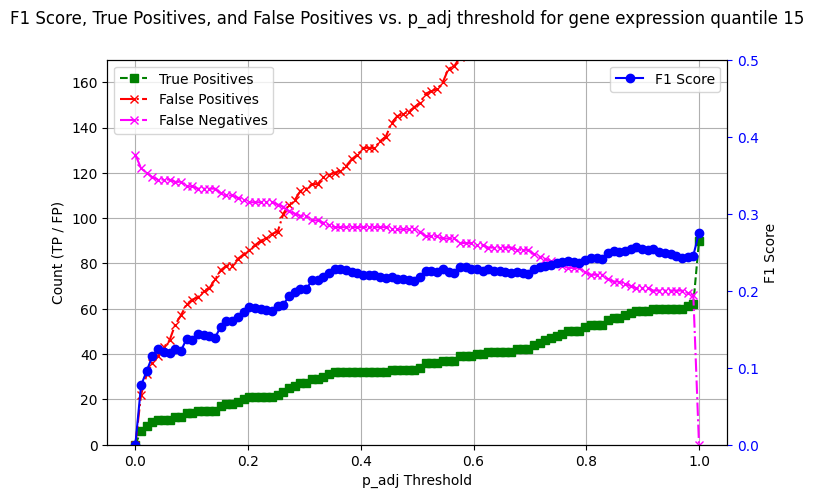

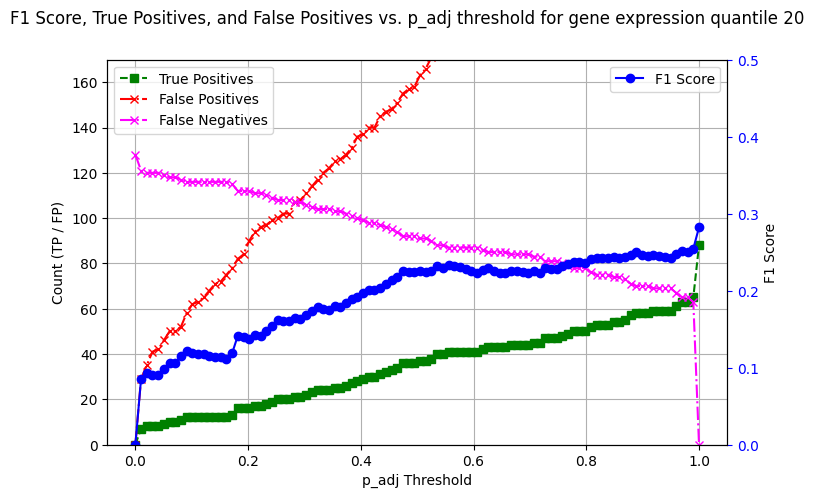

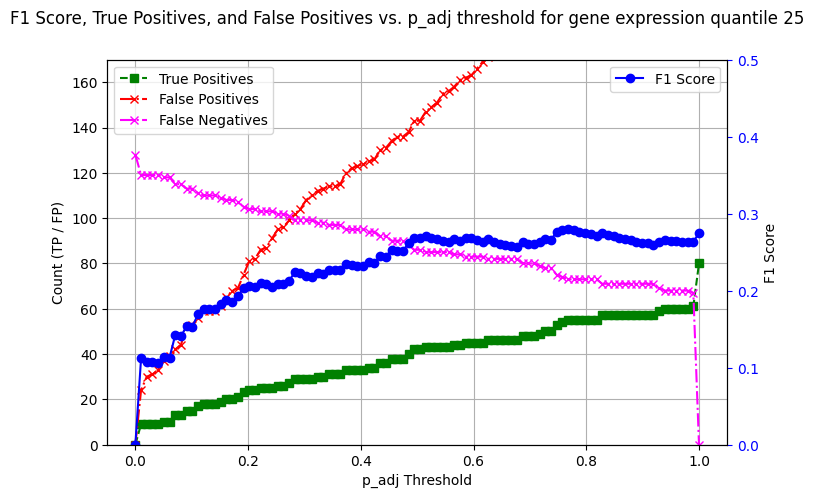

In [51]:
def process_prediction_data(prediction_data):
    known_sli_filtered = filter_benchmark_data(positive_bm_df, prediction_data)

    known_nonsli_filtered = filter_benchmark_data(negative_bm_df, prediction_data)

    known_sli_table = dictionary_to_df(known_sli_filtered)

    known_nonsli_table = dictionary_to_df(known_nonsli_filtered)

    return known_sli_table, known_nonsli_table

all_5_quantiles_sli_table = all_5_quantiles_nonsli_table = pd.DataFrame()

for quantile in range(5, 30, 5):
    prediction_data = globals().get(f"prediction_data_Q{quantile}")
    if prediction_data is not None:
        known_sli_table, known_nonsli_table = process_prediction_data(prediction_data)
        plot_F1_score(known_sli_table, known_nonsli_table, quantile=quantile)
        column_name = f"p_adj_Q{quantile}"
        all_5_quantiles_sli_table[column_name] = known_sli_table["p_adj"]
        all_5_quantiles_nonsli_table[column_name] = known_nonsli_table["p_adj"]

In [56]:
all_5_quantiles_sli_table["mutant"] = known_sli_table["mutant"]

all_5_quantiles_sli_table["gene"] = known_sli_table["gene"]

print(all_5_quantiles_sli_table)

     p_adj_Q5  p_adj_Q10  p_adj_Q15  p_adj_Q20  p_adj_Q25  mutant    gene
0    1.000000   1.000000   1.000000   1.000000   1.000000  ARID1A    RRM2
1    0.530385   0.400100   0.536135   0.552900   1.000000  ARID1A   CHEK1
2    0.505600   0.174918   0.068108   0.125440   1.000000  ARID1A  MAP3K1
3    0.162479   0.008915   0.004983   0.008462   1.000000  ARID1A     APC
4    0.992384   1.000000   1.000000   1.000000   0.569981  ARID1A     SMO
..        ...        ...        ...        ...        ...     ...     ...
123  1.000000   0.993304   1.000000   0.720131   0.743212   SETD2    TSC1
124  0.740201   1.000000   1.000000   0.010395   0.016996   SETD2    CDK9
125  0.709340   1.000000   1.000000   0.636022   0.611075   SETD2   HDAC2
126  0.900017   1.000000   1.000000   0.724404   0.431919   SETD2     SMO
127  1.000000   0.382349   0.114585   1.000000   1.000000   SETD2     ATM

[128 rows x 7 columns]


In [ ]:
def df_to_dictionary(df):
    